Bibliotecas importadas com sucesso.
Carregando os dados...
DataFrame carregado com sucesso.
Função de features segura definida.
Preparando os dados de treino e teste...
Dados divididos: 4536 para treino, 504 para teste.

Iniciando o treinamento do modelo de Regressão Linear (versão corrigida)...
Treinamento concluído em 0.00 segundos.

--- Resultados (Corrigidos) do Modelo de Regressão Linear ---
MAE (Mean Absolute Error): 0.0484
RMSE (Root Mean Squared Error): 0.0675

Gerando gráfico da previsão...


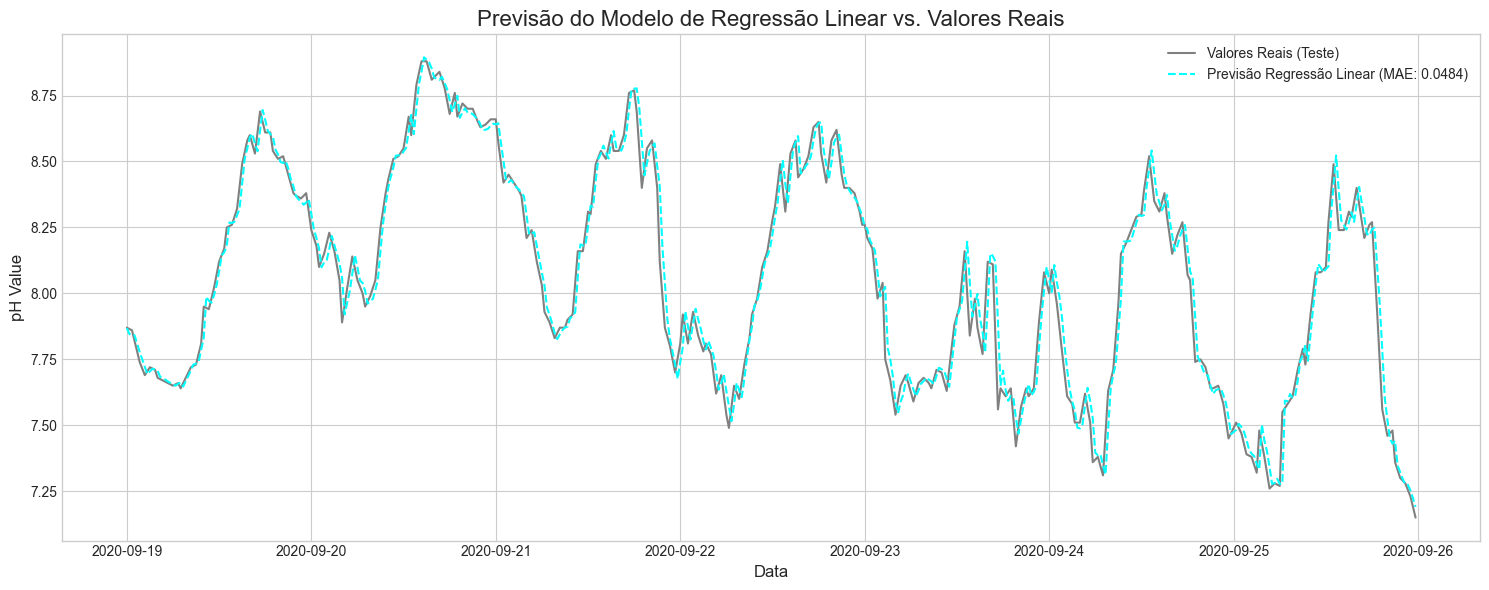

In [8]:
# --- Bibliotecas Essenciais ---
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import time

print("Bibliotecas importadas com sucesso.")

# --- 1. Carregamento dos Dados ---
print("Carregando os dados...")
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)
print("DataFrame carregado com sucesso.")

# --- 2. Função de Engenharia de Features (VERSÃO SEGURA CONTRA DATA LEAKAGE) ---
def create_safe_features(df, target_variable='ph'):
    """
    Cria features de séries temporais garantindo que NENHUMA informação do 
    passo de tempo atual seja usada nos preditores.
    """
    features_list = []
    
    # Lags (olham para o passado, são seguros)
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    for lag in lags_list:
        feature_lag = df[target_variable].shift(lag)
        feature_lag.name = f'{target_variable}_lag_{lag}'
        features_list.append(feature_lag)
        
    # Janelas Deslizantes (COM A CORREÇÃO .shift(1) para usar apenas dados do passado)
    window_sizes_list = [2, 4, 8]
    for window in window_sizes_list:
        feature_mean = df[target_variable].rolling(window=window).mean().shift(1)
        feature_mean.name = f'{target_variable}_rolling_mean_{window}'
        features_list.append(feature_mean)
        
        feature_std = df[target_variable].rolling(window=window).std().shift(1)
        feature_std.name = f'{target_variable}_rolling_std_{window}'
        features_list.append(feature_std)

    # Combinar apenas as features criadas em um novo DataFrame
    features_df = pd.concat(features_list, axis=1)
    
    # Juntar o alvo 'ph' com as suas features correspondentes
    # Isso garante que não estamos a incluir outras variáveis exógenas do mesmo timestep
    final_df = pd.concat([df[[target_variable]], features_df], axis=1)
    
    return final_df.dropna()

print("Função de features segura definida.")
df_featured = create_safe_features(df, target_variable='ph')

# --- 3. Preparação dos Dados de Treino e Teste ---
print("Preparando os dados de treino e teste...")

FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]

test_size = 7 * 24 * 3 
X_train, y_train = X[:-test_size], y[:-test_size]
X_test, y_test = X[-test_size:], y[-test_size:]
print(f"Dados divididos: {len(X_train)} para treino, {len(X_test)} para teste.")

# --- 4. Treinamento do Modelo de Regressão Linear ---
print("\nIniciando o treinamento do modelo de Regressão Linear (versão corrigida)...")
start_time = time.time()
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(X_train, y_train)
end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- 5. Previsão e Avaliação ---
lr_forecast = lr_model.predict(X_test)
mae_lr = mean_absolute_error(y_test, lr_forecast)
rmse_lr = np.sqrt(mean_squared_error(y_test, lr_forecast))
print("\n--- Resultados (Corrigidos) do Modelo de Regressão Linear ---")
print(f"MAE (Mean Absolute Error): {mae_lr:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_lr:.4f}")

# --- 6. Visualização da Previsão ---
print("\nGerando gráfico da previsão...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray', linewidth=1.5)
ax.plot(y_test.index, lr_forecast, label=f'Previsão Regressão Linear (MAE: {mae_lr:.4f})', color='cyan', linestyle='--')
ax.set_title('Previsão do Modelo de Regressão Linear vs. Valores Reais', fontsize=16)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('pH Value', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

In [9]:
# --- 8. Análise dos Coeficientes do Modelo Linear ---
print("Extraindo e analisando os coeficientes do modelo...")

# Criar um DataFrame para visualizar os coeficientes de forma clara
# O modelo guarda os coeficientes no atributo .coef_
# Os nomes das features estão em X_train.columns
coefficients_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient (Peso)': lr_model.coef_
})

# Adicionar o valor absoluto do coeficiente para ordenar pela importância
coefficients_df['Absolute_Coefficient'] = coefficients_df['Coefficient (Peso)'].abs()

# Ordenar pela importância (magnitude)
coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

# Remover a coluna auxiliar
coefficients_df = coefficients_df.drop(columns='Absolute_Coefficient')

print("\n--- Importância das Features Segundo a Regressão Linear ---")
# Usamos 'display' para uma formatação de tabela mais bonita no Jupyter
display(coefficients_df.head(15)) # Mostramos as 15 mais importantes

# Opcional: Visualizar o intercepto do modelo
intercept = lr_model.intercept_
print(f"\nConstante/Intercepto do Modelo: {intercept:.4f}")

Extraindo e analisando os coeficientes do modelo...

--- Importância das Features Segundo a Regressão Linear ---


,Feature,Coefficient (Peso)
0,ph_lag_1,0.775913
14,ph_rolling_mean_2,0.293908
17,ph_rolling_std_4,0.224217
1,ph_lag_2,-0.188097
16,ph_rolling_mean_4,0.142217
15,ph_rolling_std_2,0.114515
7,ph_lag_8,-0.098366
6,ph_lag_7,0.066739
18,ph_rolling_mean_8,0.060847
19,ph_rolling_std_8,-0.047427



Constante/Intercepto do Modelo: 0.0210
